In [1]:
import os
import pickle
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from kerascv.model_provider import get_model as kecv_get_model
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
IMG_DIR = './data/data_imgs_preprocessed'
TRAIN_DATA = './data/train_data_1.csv'
TEST_DATA = './data/test_data_1.csv'

HISTORY = './model/test_history.pkl'
WEIGHTS = './model/weights.hdf5'

In [3]:
# EARLY_STOPPING_PATIENCE = 8
BATCH_SIZE = 40
EPOCHS = 20

In [4]:
def prepare_datas( path ):
    df = pd.read_csv(path)
    
    ids = df['tconst']
    paths = np.array([ os.path.join(IMG_DIR, f'{id}.jpg') for id in ids ])
    x = []
    for i, path in enumerate(paths):
        percentage_loaded = round( (i/len(paths)) * 100, 2)
        if i % 1000 == 0:
            print(f'Loaded: {percentage_loaded}%')  
        x.append(cv2.imread(path))
    print(f'Loaded: 100%')  
    plt.imshow(cv2.cvtColor(x[0], cv2.COLOR_BGR2RGB))
    plt.show()
    x = np.array(x)

    outputs = {}
    # labels = np.arange(1, 10.1, 0.1)
    labels = np.arange(1, 11)
    for label in labels:
        outputs[str(label)] = 0
        
    results = df['averageRating']
    # results = [str(round(label, 1)) for label in results]
    results = [str(round(label)) for label in results]

    y = []
    for result in results:
        output_copy = outputs.copy()
        output_copy[result] = 1
        y.append(np.fromiter(output_copy.values(),  dtype=int))
    y = np.array(y)
    
    print('x shape:', x.shape)       
    print('y shape:', y.shape)    
    return x, y

def convert_ouptupt_to_rating( output ):
    # labels = np.arange(1, 10.1, 0.1)
    # labels = [str(round(label, 1)) for label in labels]
    labels = np.arange(1, 11)
    labels = [str(round(label)) + ' - ' + str(round(label) + 1) for label in labels]
    for i, elems in enumerate(output):
        if elems == 1:
            return labels[i]

In [5]:
def save_history(history, path):
    with open(path, 'wb') as output:
        pickle.dump(history, output)

def load_history(path):
    with open(path, 'rb') as input:
        history = pickle.load(input)
    return history

In [6]:
# output_labels = np.arange(1, 10.1, 0.1)
# output_labels = [ str(round(number, 1)) for number in output_labels ]

output_labels = np.arange(1, 11)
output_labels = [ str(round(number)) for number in output_labels ]

Loaded: 0.0%
Loaded: 3.82%
Loaded: 7.64%
Loaded: 11.45%
Loaded: 15.27%
Loaded: 19.09%
Loaded: 22.91%
Loaded: 26.72%
Loaded: 30.54%
Loaded: 34.36%
Loaded: 38.18%
Loaded: 42.0%
Loaded: 45.81%
Loaded: 49.63%
Loaded: 53.45%
Loaded: 57.27%
Loaded: 61.09%
Loaded: 64.9%
Loaded: 68.72%
Loaded: 72.54%
Loaded: 76.36%
Loaded: 80.17%
Loaded: 83.99%
Loaded: 87.81%
Loaded: 91.63%
Loaded: 95.45%
Loaded: 99.26%
Loaded: 100%


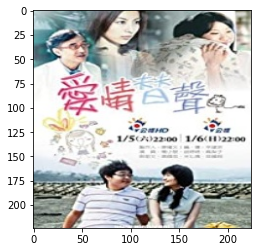

x shape: (26193, 224, 224, 3)
y shape: (26193, 10)


In [7]:
x_train, y_train = prepare_datas(TRAIN_DATA)

Loaded: 0.0%
Loaded: 33.81%
Loaded: 67.61%
Loaded: 100%


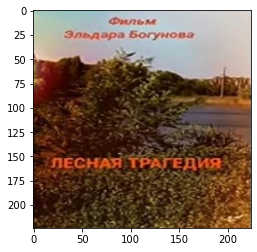

x shape: (2958, 224, 224, 3)
y shape: (2958, 10)


In [8]:
x_test, y_test = prepare_datas(TEST_DATA)

In [9]:
base_model = kecv_get_model("ZFNet", pretrained=True)
base_model.trainable = False

output_model = base_model.output
# output_model = MaxPooling2D(pool_size=(2, 2))(output_model)
output_model = Dense(len(output_labels))(output_model)
output_model = Activation('softmax')(output_model)

model = Model(inputs=base_model.input, outputs=output_model)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 226, 226, 3)       0         
_________________________________________________________________
features/stage1/unit1/conv/c (None, 110, 110, 96)      14208     
_________________________________________________________________
features/stage1/unit1/conv/a (None, 110, 110, 96)      0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 110, 110, 96)      0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 112, 112, 96)      0         
_________________________________________________________________
features/stage1/pool/pool (M (None, 55, 55, 96)        0   

In [10]:
# early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience= EARLY_STOPPING_PATIENCE)
checkpoint_saving = ModelCheckpoint(WEIGHTS, save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=0.00001 , 
                                   patience=10, verbose=1, min_delta=1e-4, mode='min')

In [11]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, 
              callbacks=[early_stopping, checkpoint_saving, reduce_lr_rate],
              validation_data=(x_test, y_test))
save_history(history.history, HISTORY)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 26193 samples, validate on 2958 samples
Epoch 1/20
 - 2148s - loss: 1.9551 - accuracy: 0.2884 - val_loss: 1.7138 - val_accuracy: 0.3039
Epoch 2/20
 - 2102s - loss: 1.7014 - accuracy: 0.2990 - val_loss: 1.7146 - val_accuracy: 0.3039
Epoch 3/20
 - 2084s - loss: 1.6952 - accuracy: 0.3029 - val_loss: 1.7171 - val_accuracy: 0.2779
Epoch 4/20
 - 2091s - loss: 1.6952 - accuracy: 0.2978 - val_loss: 1.7146 - val_accuracy: 0.3039
Epoch 5/20
 - 2088s - loss: 1.6952 - accuracy: 0.2985 - val_loss: 1.7157 - val_accuracy: 0.3039
Epoch 6/20
 - 2083s - loss: 1.6953 - accuracy: 0.3016 - val_loss: 1.7177 - val_accuracy: 0.3039
Epoch 7/20
 - 2083s - loss: 1.6952 - accuracy: 0.3023 - val_loss: 1.7165 - val_accuracy: 0.3039
Epoch 8/20
 - 2084s - loss: 6.3271 - accuracy: 0.2974 - val_loss: 1.7140 - val_accuracy: 0.3039
Epoch 9/20
 - 2082s - loss: 1.7001 - accuracy: 0.3013 - val_loss: 1.7153 - val_accuracy: 0.2779
Epoch 00009: early stopping
Test score: 1.715312905211639
Test accuracy: 0.277890473604